In [15]:
#
# NOTE: This ResNet model is for predicting TC formation, using the 
#       architechture provided by CNN class. The model treats different
#       2D input fields as input channels of an image. This specific
#       program requires a set of input data from Stage 2 of the follwing
#       3-stage workflow
#       - Stage 1: reading NETCDF input and generating (X,y) data with a
#                  given image sizes, which are then saved by pickle;
#       - Stage 2: import the saved pickle (X,y) pair and build a CNN model
#                  with a given training/validation ratio, and then save
#                  the train model under tcg_CNN.model.
#       - Stage 3: import the trained model from Stage 2, and make a list
#                  of prediction from normalized test data.
#
# INPUT: This Stage 2 script requires two specific input datasets that are
#        generated from Step 1, including
#        1. tcg_ResNet_X.pickle: data contains all images of yes/no TCG events, 
#           each of these images must have 12 channels
#        2. tcg_ResNet_y.pickle: data contains all labels of each image (i.e., 
#           yes or no) of TCG corresponding to each data in X.
#
#        Remarks: Note that each channel must be normalized separealy. Also
#        the script requires a large memory allocation. So users need to have
#        GPU version to run this.
#
# OUTPUT: A ResNet model built from Keras saved under tcg_ResNet.model
#
# HIST: - 27, May 23: Created by CK from the open sourse ResNet50 model in 
#                     the deep learning class
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu)
#===============================================================================
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

In [16]:
#
# Bulding the identity_block for ResNet with 3 convolutional layers
#
def identity_block(X, f, filters, training=True, initializer=random_uniform):        
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. Will need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X) 
    
    return X

In [17]:
# 
# Building the convolutional_block for ResNet with 3 convolutional layers
#
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    
    # Shortcut path 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
# 
# Building the ResNet50 model for TCG classifications
#
def ResNet50(input_shape = (30, 30, 12), classes = 1):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((2, 2))(X_input)
    
    # Stage 1 - 1 layer
    X = Conv2D(64, (5, 5), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2 - 9 layers
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    # Stage 3 - 12 layers
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
   
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 - 18 layers    
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 - 9 layers    
    #X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    #X = identity_block(X, 3, [512, 512, 2048])
    #X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = AveragePooling2D()(X)

    # output layer - 1 dense layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [18]:
#
# call ResNet model and printout the summary. Note that the number of parameters for the
# batch normalization is computed as 4x # of filter due to the use of 4 parameters:
# [gamma weights, beta weights, moving_mean(non-trainable), moving_variance(non-trainable)]
# for each filter normalization.
#
model = ResNet50(input_shape = (30, 30, 12), classes = 1)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 30, 30, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 34, 34, 12)  0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_68 (Conv2D)             (None, 15, 15, 64)   19264       ['zero_padding2d_3[0][0]']       
                                                                                            

 activation_71 (Activation)     (None, 7, 7, 64)     0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 7, 7, 256)    16640       ['activation_71[0][0]']          
                                                                                                  
 batch_normalization_78 (BatchN  (None, 7, 7, 256)   1024        ['conv2d_78[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_22 (Add)                   (None, 7, 7, 256)    0           ['activation_69[0][0]',          
                                                                  'batch_normalization_78[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 add_25 (Add)                   (None, 4, 4, 512)    0           ['activation_78[0][0]',          
                                                                  'batch_normalization_88[0][0]'] 
                                                                                                  
 activation_81 (Activation)     (None, 4, 4, 512)    0           ['add_25[0][0]']                 
                                                                                                  
 conv2d_89 (Conv2D)             (None, 4, 4, 128)    65664       ['activation_81[0][0]']          
                                                                                                  
 batch_normalization_89 (BatchN  (None, 4, 4, 128)   512         ['conv2d_89[0][0]']              
 ormalization)                                                                                    
          

 conv2d_99 (Conv2D)             (None, 2, 2, 256)    262400      ['activation_90[0][0]']          
                                                                                                  
 batch_normalization_99 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_91 (Activation)     (None, 2, 2, 256)    0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 conv2d_100 (Conv2D)            (None, 2, 2, 256)    590080      ['activation_91[0][0]']          
                                                                                                  
 batch_normalization_100 (Batch  (None, 2, 2, 256)   1024        ['conv2d_100[0][0]']             
 Normaliza

                                                                                                  
 activation_101 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 2, 2, 1024)   263168      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 2, 2, 1024)  4096        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_32 (Add)                   (None, 2, 2, 1024)   0           ['activation_99[0][0]',          
                                                                  'batch_normalization_110[0][0]']
          

In [25]:
#
# define the loss function and accuracy criteria
#
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.3)])

In [26]:
#
# read in data output from Stage 1
#
import pickle
pickle_in = open("tcg_ResNet_X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("tcg_ResNet_Y.pickle","rb")
Y = pickle.load(pickle_in)
Y = np.array(Y)
number_channels=X.shape[3]
print('Input shape of the X features data: ',X.shape)
print('Input shape of the Y label data: ',Y.shape)
print('Number of input channel extracted from X is: ',number_channels)
#
# normalize the data before training the model
#
nsample = X.shape[0]
for i in range(nsample):
    for var in range(number_channels):    
        maxvalue = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('Normalization factor for sample and channel',i,var,', is: ',abs(maxvalue))
        X[i,:,:,var] = X[i,:,:,var]/abs(maxvalue)
        #maxnew = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('-->After normalization of sample and channel',i,var,', is: ',abs(maxnew))
        #input('Enter to continue...')
print("Finish normalization...")

print ("number of input examples = " + str(X.shape[0]))
print ("X shape: " + str(X.shape))
print ("Y shape: " + str(Y.shape))

Input shape of the X features data:  (704, 30, 30, 12)
Input shape of the Y label data:  (704,)
Number of input channel extracted from X is:  12
Finish normalization...
number of input examples = 704
X shape: (704, 30, 30, 12)
Y shape: (704,)


In [27]:
#
# define the callbacks and fit the model
#
from tensorflow import keras
callbacks=[keras.callbacks.ModelCheckpoint("tcg_ResNet.model",save_best_only=True)]
#callbacks=[keras.callbacks.EarlyStopping(
#           monitor='val_f1_score',
#           mode='max',
#           verbose=1,
#           patience=20,
#           restore_best_weights=True),
#          keras.callbacks.ModelCheckpoint(
#            filepath=f"outputs/tcg_ResNet_model",
#            monitor='val_f1_score',
#            mode='max',
#            save_best_only=True)]
history = model.fit(X, Y, epochs = 10, batch_size = 32, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
19/20 [===========================>..] - ETA: 0s - loss: 0.2855 - binary_accuracy: 0.9161 

INFO:tensorflow:Assets written to: tcg_ResNet.model/assets


INFO:tensorflow:Assets written to: tcg_ResNet.model/assets


20/20 [==============================] - 16s 655ms/step - loss: 0.2860 - binary_accuracy: 0.9163 - val_loss: 0.1212 - val_binary_accuracy: 0.9859
Epoch 2/10
19/20 [===========================>..] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.9753

INFO:tensorflow:Assets written to: tcg_ResNet.model/assets


INFO:tensorflow:Assets written to: tcg_ResNet.model/assets


20/20 [==============================] - 12s 621ms/step - loss: 0.0947 - binary_accuracy: 0.9763 - val_loss: 0.0409 - val_binary_accuracy: 0.9859
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.0597 - binary_accuracy: 0.9731 - val_loss: 0.1231 - val_binary_accuracy: 0.9437
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.0372 - binary_accuracy: 0.9889 - val_loss: 0.1039 - val_binary_accuracy: 0.9718
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.0240 - binary_accuracy: 0.9858 - val_loss: 0.1439 - val_binary_accuracy: 0.9296
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - loss: 0.0092 - binary_accuracy: 0.9968 - val_loss: 0.1341 - val_binary_accuracy: 0.9577
Epoch 7/10
20/20 [==============================] - 0s 20ms/step - loss: 0.0146 - binary_accuracy: 0.9937 - val_loss: 0.0747 - val_binary_accuracy: 0.9718
Epoch 8/10
20/20 [==============================] - 0s 20ms/step - loss: 0.0099

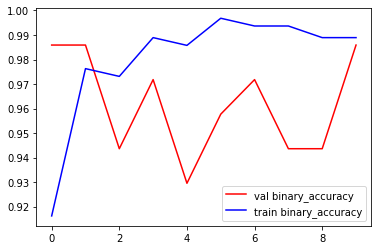

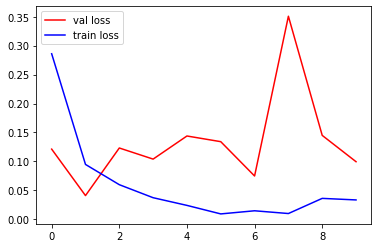

In [29]:
import matplotlib.pyplot as plt
#print(history.__dict__)
#print(history.history)
val_accuracy = history.history['val_binary_accuracy']
accuracy = history.history['binary_accuracy']
epochs = history.epoch 
plt.plot(epochs,val_accuracy,'r',label="val binary_accuracy")
plt.plot(epochs,accuracy,'b',label="train binary_accuracy")
plt.legend()

plt.figure()
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(epochs,val_loss,'r',label="val loss")
plt.plot(epochs,loss,'b',label="train loss")
plt.legend()
plt.show()